In [1]:
import csv
from xml.etree import ElementTree
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.ticker import StrMethodFormatter
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats as stats
from pyclustertend import hopkins, vat, assess_tendency_by_mean_metric_score
from sklearn.preprocessing import scale, MinMaxScaler, minmax_scale, RobustScaler,robust_scale
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import silhouette_score
import sklearn.metrics as compute_metrics
import seaborn as sns

In [2]:
# real_labels_file = "C:/Users/aprodea/work/metrics-tax-compare/analysis/labelled_data_ext.csv"
# real_labels_file = "C:/Users/aprodea/work/deloitte-tax-i/analysis/labelled_data_ext.csv"
real_labels_file = None

# metrics_labelled_file = "C:/Users/aprodea/work/deloitte-tax-i/analysis/last/classification/all_labels.csv"
# metrics_labelled_file = "C:/Users/aprodea/work/metrics-tax-compare/analysis/tag-1.1.1/classification/2_all_labels.csv"
# metrics_labelled_file = "C:/Users/aprodea/work/deloitte-tax-i/analysis/commit_23-01-20/classification/2_all_labels.csv"
metrics_labelled_file = "C:/Users/aprodea/work/experiment-projects/sharex/analysis/v12/classification/2_all_labels.csv"

# chg_lines_file = "C:/Users/aprodea/work/metrics-tax-compare/analysis/tag-1.1.1/merged/change_lines.csv"
# chg_lines_file = "C:/Users/aprodea/work/deloitte-tax-i/analysis/commit_23-01-20/merged/change_lines.csv"
chg_lines_file = "C:/Users/aprodea/work/experiment-projects/sharex/analysis/v12/merged/change_lines.csv"

var_list = ['LOC', 'CC', 'NP', 'NV', 'NEST', 'Ca', 'Ce', 'NChg', 'NCall']
label_list = ['CLevel_threshold', 'CLevel_k_means', 'CLevel_em']

# plots_save_to_location = "C:/Users/aprodea/work/metrics-tax-compare/analysis/tag-1.1.1/classification/2_plots"
# plots_save_to_location = "C:/Users/aprodea/work/deloitte-tax-i/analysis/commit_23-01-20/classification/2_plots/"
plots_save_to_location = "C:/Users/aprodea/work/experiment-projects/sharex/analysis/v12/classification/2_plots/"

def get_labelled_data():
    data = pd.read_csv(metrics_labelled_file, sep=';')
    return data

labelled_df = get_labelled_data()
labelled_df

,Method,LOC,CC,NP,NV,NEST,Ca,Ce,NChg,NCall,CLevel_threshold,CLevel_k_means,CLevel_em
0,ShareX.ScreenCaptureLib.WindowInfo.WindowInfo(...,2.0,1.0,1,0.0,0.0,5,0,1.0,0.0,low,regular,high
1,ShareX.ScreenCaptureLib.WindowInfo.Activate(),1.0,1.0,0,0.0,0.0,1,2,1.0,0.0,low,low,low
2,ShareX.ScreenCaptureLib.WindowInfo.ToString(),1.0,1.0,0,1.0,0.0,0,1,1.0,0.0,low,low,low
3,ShareX.HelpersLib.CustomToolStripProfessionalR...,2.0,1.0,0,0.0,0.0,2,0,1.0,0.0,low,low,low
4,ShareX.HelpersLib.LabeledComboBox.add_Selected...,1.0,1.0,1,0.0,0.0,1,0,1.0,11.0,regular,regular,regular
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3682,ShareX.Setup.Program.UploadLatestFile(),5.0,3.0,0,2.0,1.0,1,2,1.0,0.0,low,low,low
3683,ShareX.Setup.Program.Program(),4.0,1.0,0,0.0,0.0,0,0,1.0,0.0,low,low,low
3684,ShareX.NativeMessagingHost.Program.Main(String[]),5.0,3.0,1,2.0,2.0,0,2,5.0,0.0,low,regular,regular
3685,ShareX.NativeMessagingHost.Program.Run(),14.0,6.0,0,10.0,3.0,1,7,8.0,0.0,regular,low,low


# Using expert knowledge

In [3]:
real_labels_data = None
if real_labels_file is not None:
    real_labels_data = pd.read_csv(real_labels_file, sep=';')
    print(real_labels_data.describe())

In [4]:

def print_cm(cm, labels):
    """pretty print for confusion matrixes"""
    column_width = 10
    # Print header
    header = " " * column_width
    for label in labels:
        header += "%{0}s".format(column_width) % label
    print(header)
    # Print rows
    for i, label1 in enumerate(labels):
        row_text = "%{0}s".format(column_width) % label1
        for j in range(len(labels)):
            cell = "%{0}.1f".format(column_width) % cm[i, j]
            row_text += cell
        print(row_text)


def classification_report(real, predicted):
    labels = ['high', 'regular', 'low']
    ari = adjusted_rand_score(labels_true=real, labels_pred=predicted)
    acc = compute_metrics.accuracy_score(y_true=real, y_pred=predicted)
    report = compute_metrics.classification_report(y_true=real, y_pred=predicted, labels=labels)
    conf_matrix = compute_metrics.confusion_matrix(y_true=real, y_pred=predicted, labels=labels)
    print('ARI ', ari)
    print('Accuracy ', acc)
    print(report)
    print('Confusion matrix')
    print_cm(conf_matrix, labels)


def classification_report_for_all():
    real_labels_data = pd.read_csv(real_labels_file, sep=';')
    
    metrics_labelled_data = pd.read_csv(metrics_labelled_file, sep=';')

    data_combined = pd.merge(left=real_labels_data[['Method', 'CLevel']],
                             right=metrics_labelled_data[['Method', 'CLevel_threshold', 'CLevel_k_means', 'CLevel_em']],
                             on='Method', how='inner')

    pred_labels_var = ['CLevel_threshold', 'CLevel_k_means', 'CLevel_em']
    for y_pred in pred_labels_var:
        print('------- {} ------'.format(y_pred))
        classification_report(data_combined['CLevel'], data_combined[y_pred])

if real_labels_data is not None:
    classification_report_for_all()

# Using changed lines

In [5]:

chg_lines_data = pd.read_csv(chg_lines_file, sep=';')
chg_lines_data

,Method_Parsed,Previous_Method_Parsed,ChgLines
0,ShareX.ApplicationConfig.ApplicationConfig(),ShareX.ApplicationConfig.ApplicationConfig(),0
1,ShareX.ApplicationConfig.List<HotkeyType>(),ShareX.ApplicationConfig.List<HotkeyType>(),0
2,ShareX.HotkeySelectionControl.Dispose(Boolean),ShareX.HotkeySelectionControl.Dispose(Boolean),0
3,ShareX.HotkeySelectionControl.InitializeCompon...,ShareX.HotkeySelectionControl.InitializeCompon...,1
4,ShareX.HotkeySelectionControl.if(),ShareX.HotkeySelectionControl.if(),0
...,...,...,...
5634,ShareX.ThumbnailSizeForm.InitializeComponent(),NaN,1
5635,ShareX.ThumbnailSizeForm.ThumbnailSizeForm(),NaN,0
5636,ShareX.ThumbnailSizeForm.ThumbnailSizeForm(Size),NaN,0
5637,"ShareX.ThumbnailSizeForm.btnOK_Click(Object,Ev...",NaN,0


In [6]:
df = pd.merge(labelled_df, chg_lines_data[['Previous_Method_Parsed', 'ChgLines']], how='inner', left_on='Method', right_on='Previous_Method_Parsed')
df

,Method,LOC,CC,NP,NV,NEST,Ca,Ce,NChg,NCall,CLevel_threshold,CLevel_k_means,CLevel_em,Previous_Method_Parsed,ChgLines
0,ShareX.ScreenCaptureLib.WindowInfo.WindowInfo(...,2.0,1.0,1,0.0,0.0,5,0,1.0,0.0,low,regular,high,ShareX.ScreenCaptureLib.WindowInfo.WindowInfo(...,0
1,ShareX.ScreenCaptureLib.WindowInfo.Activate(),1.0,1.0,0,0.0,0.0,1,2,1.0,0.0,low,low,low,ShareX.ScreenCaptureLib.WindowInfo.Activate(),1
2,ShareX.ScreenCaptureLib.WindowInfo.ToString(),1.0,1.0,0,1.0,0.0,0,1,1.0,0.0,low,low,low,ShareX.ScreenCaptureLib.WindowInfo.ToString(),0
3,ShareX.HelpersLib.CustomToolStripProfessionalR...,2.0,1.0,0,0.0,0.0,2,0,1.0,0.0,low,low,low,ShareX.HelpersLib.CustomToolStripProfessionalR...,0
4,ShareX.HelpersLib.LabeledComboBox.LabeledCombo...,3.0,1.0,0,0.0,0.0,1,1,1.0,28.0,regular,low,low,ShareX.HelpersLib.LabeledComboBox.LabeledCombo...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2107,"ShareX.Setup.Helpers.Zip(String,String)",2.0,1.0,2,2.0,0.0,1,0,1.0,0.0,low,regular,high,"ShareX.Setup.Helpers.Zip(String,String)",14
2108,"ShareX.Setup.Helpers.CheckArguments(String[],S...",8.0,5.0,2,6.0,3.0,1,0,1.0,0.0,regular,regular,high,"ShareX.Setup.Helpers.CheckArguments(String[],S...",0
2109,ShareX.NativeMessagingHost.Program.Main(String[]),5.0,3.0,1,2.0,2.0,0,2,5.0,0.0,low,regular,regular,ShareX.NativeMessagingHost.Program.Main(String[]),0
2110,ShareX.NativeMessagingHost.Program.Run(),14.0,6.0,0,10.0,3.0,1,7,8.0,0.0,regular,low,low,ShareX.NativeMessagingHost.Program.Run(),0


In [7]:
df.isna().sum()

Method                    0
LOC                       0
CC                        0
NP                        0
NV                        0
NEST                      0
Ca                        0
Ce                        0
NChg                      0
NCall                     0
CLevel_threshold          0
CLevel_k_means            0
CLevel_em                 0
Previous_Method_Parsed    0
ChgLines                  0
dtype: int64

In [8]:
df[df['ChgLines']>0]

,Method,LOC,CC,NP,NV,NEST,Ca,Ce,NChg,NCall,CLevel_threshold,CLevel_k_means,CLevel_em,Previous_Method_Parsed,ChgLines
1,ShareX.ScreenCaptureLib.WindowInfo.Activate(),1.0,1.0,0,0.0,0.0,1,2,1.0,0.0,low,low,low,ShareX.ScreenCaptureLib.WindowInfo.Activate(),1
9,ShareX.HelpersLib.ToolStripBorderRight.OnPaint...,2.0,1.0,1,1.0,0.0,0,0,1.0,126316.0,high,regular,regular,ShareX.HelpersLib.ToolStripBorderRight.OnPaint...,5
11,ShareX.HelpersLib.ToolStripButtonCounter.Updat...,23.0,5.0,0,11.0,2.0,1,5,2.0,6.0,regular,low,low,ShareX.HelpersLib.ToolStripButtonCounter.Updat...,4
16,ShareX.HelpersLib.JsonHelpers.DeserializeFromS...,4.0,2.0,1,4.0,3.0,0,1,1.0,0.0,low,regular,regular,ShareX.HelpersLib.JsonHelpers.DeserializeFromS...,1
17,ShareX.HelpersLib.JsonHelpers.DeserializeFromF...,6.0,3.0,1,6.0,4.0,1,1,1.0,0.0,regular,regular,regular,ShareX.HelpersLib.JsonHelpers.DeserializeFromF...,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2081,ShareX.IndexerLib.IndexerHtml.GetFolderNameRow...,15.0,8.0,2,9.0,3.0,1,12,5.0,2.0,regular,regular,high,ShareX.IndexerLib.IndexerHtml.GetFolderNameRow...,11
2083,ShareX.IndexerLib.IndexerHtml.GetFooter(),1.0,1.0,0,2.0,0.0,1,0,5.0,1.0,low,low,low,ShareX.IndexerLib.IndexerHtml.GetFooter(),1
2096,ShareX.IndexerLib.IndexerText.GetFooter(),1.0,1.0,0,2.0,0.0,1,0,2.0,0.0,low,low,low,ShareX.IndexerLib.IndexerText.GetFooter(),1
2103,ShareX.Setup.Helpers.DownloadFile(String),5.0,1.0,1,3.0,2.0,1,0,3.0,0.0,low,regular,regular,ShareX.Setup.Helpers.DownloadFile(String),5


In [9]:
custom_dict = {'low': 0, 'regular': 1, 'high': 2}

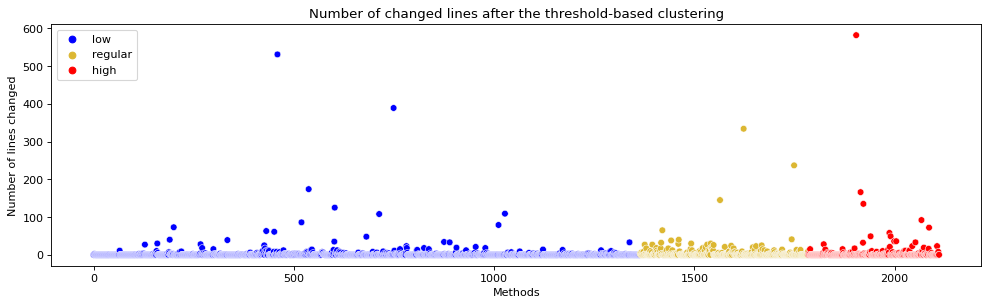

In [10]:
sub_df1 = df[['Method','CLevel_threshold', 'ChgLines']]
sub_df1 = sub_df1.sort_values(by=['CLevel_threshold'], key=lambda x: x.map(custom_dict), ignore_index=True)
sub_df1['method_idx'] = sub_df1.index

fig, ax = plt.subplots(figsize=(15,4), dpi= 80)
sns.scatterplot(data=sub_df1, x="method_idx", y="ChgLines", hue="CLevel_threshold", 
                palette={'low':'blue', 'regular':'#DCB732', 'high':'red'})
plt.legend(loc='upper left')
plt.title('Number of changed lines after the threshold-based clustering')
plt.ylabel('Number of lines changed')
plt.xlabel('Methods')
plt.savefig(plots_save_to_location + '/chg-lines_threshold.pdf', bbox_inches = 'tight', pad_inches = 0)

In [11]:
grouped_df1 = sub_df1.groupby('CLevel_threshold')
print(grouped_df1[['ChgLines']].sum())
grouped_df1[['ChgLines']].describe()

                  ChgLines
CLevel_threshold          
high                  1843
low                   3313
regular               2085


ChgLines                                                
                    count      mean        std  min  25%  50%  75%    max
CLevel_threshold                                                         
high                327.0  5.636086  35.306793  0.0  0.0  0.0  1.5  582.0
low                1365.0  2.427106  19.965513  0.0  0.0  0.0  0.0  531.0
regular             420.0  4.964286  22.129930  0.0  0.0  0.0  3.0  334.0

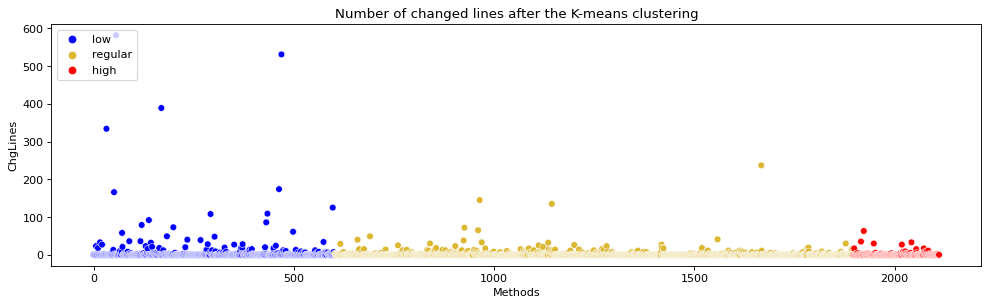

In [12]:
sub_df2 = df[['Method', 'CLevel_k_means', 'ChgLines']]
sub_df2 = sub_df2.sort_values(by=['CLevel_k_means'], key=lambda x: x.map(custom_dict), ignore_index=True)
sub_df2['method_idx'] = sub_df2.index

fig, ax = plt.subplots(figsize=(15,4), dpi= 80)
sns.scatterplot(data=sub_df2, x="method_idx", y="ChgLines", hue="CLevel_k_means", 
                palette={'low':'blue', 'regular':'#DCB732', 'high':'red'})
plt.legend(loc='upper left')
plt.title('Number of changed lines after the K-means clustering')
plt.xlabel('Methods')
plt.savefig(plots_save_to_location + '/chg-lines_k_means.pdf', bbox_inches = 'tight', pad_inches = 0)

In [13]:
grouped_df2 = sub_df2.groupby('CLevel_k_means')
print(grouped_df2[['ChgLines']].sum())
grouped_df2[['ChgLines']].describe()

                ChgLines
CLevel_k_means          
high                 421
low                 4255
regular             2565


ChgLines                                                
                  count      mean        std  min  25%  50%  75%    max
CLevel_k_means                                                         
high              215.0  1.958140   6.387277  0.0  0.0  0.0  1.0   63.0
low               603.0  7.056385  40.982576  0.0  0.0  0.0  1.0  582.0
regular          1294.0  1.982226   9.961744  0.0  0.0  0.0  1.0  237.0

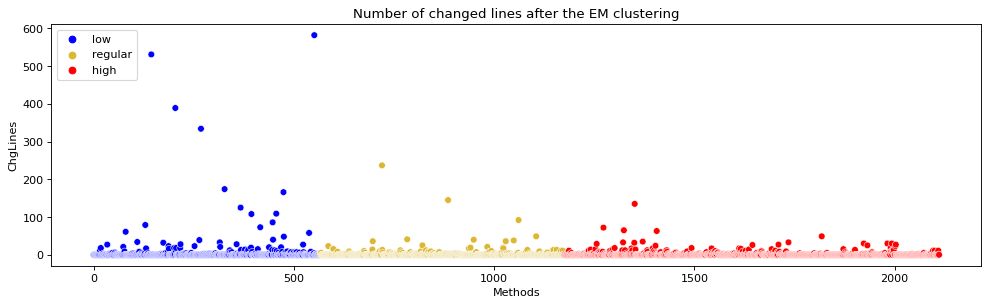

In [14]:
sub_df3 = df[['Method', 'CLevel_em', 'ChgLines']]
sub_df3 = sub_df3.sort_values(by=['CLevel_em'], key=lambda x: x.map(custom_dict), ignore_index=True)
sub_df3['method_idx'] = sub_df3.index

fig, ax = plt.subplots(figsize=(15,4), dpi= 80)
sns.scatterplot(data=sub_df3, x="method_idx", y="ChgLines", hue="CLevel_em", 
                palette={'low':'blue', 'regular':'#DCB732', 'high':'red'})
plt.legend(loc='upper left')
plt.title('Number of changed lines after the EM clustering')
plt.xlabel('Methods')
plt.savefig(plots_save_to_location + '/chg-lines_em.pdf', bbox_inches = 'tight', pad_inches = 0)

In [15]:
grouped_df3 = sub_df3.groupby('CLevel_em')
print(grouped_df3[['ChgLines']].sum())
grouped_df3[['ChgLines']].describe()

           ChgLines
CLevel_em          
high           1849
low            3965
regular        1427


ChgLines                                                
             count      mean        std  min  25%  50%  75%    max
CLevel_em                                                         
high         937.0  1.973319   7.409737  0.0  0.0  0.0  1.0  135.0
low          566.0  7.005300  42.044961  0.0  0.0  0.0  1.0  582.0
regular      609.0  2.343186  12.768516  0.0  0.0  0.0  1.0  237.0

In [16]:
m_df = df[['Method','CLevel_threshold','CLevel_k_means','CLevel_em', 'ChgLines']]
m_df = pd.melt(df, id_vars=['Method', 'ChgLines'], value_vars=['CLevel_threshold','CLevel_k_means','CLevel_em'])
m_df.columns = ['Method', 'ChgLines', 'CType', 'CLevel']
m_df

,Method,ChgLines,CType,CLevel
0,ShareX.ScreenCaptureLib.WindowInfo.WindowInfo(...,0,CLevel_threshold,low
1,ShareX.ScreenCaptureLib.WindowInfo.Activate(),1,CLevel_threshold,low
2,ShareX.ScreenCaptureLib.WindowInfo.ToString(),0,CLevel_threshold,low
3,ShareX.HelpersLib.CustomToolStripProfessionalR...,0,CLevel_threshold,low
4,ShareX.HelpersLib.LabeledComboBox.LabeledCombo...,0,CLevel_threshold,regular
...,...,...,...,...
6331,"ShareX.Setup.Helpers.Zip(String,String)",14,CLevel_em,high
6332,"ShareX.Setup.Helpers.CheckArguments(String[],S...",0,CLevel_em,high
6333,ShareX.NativeMessagingHost.Program.Main(String[]),0,CLevel_em,regular
6334,ShareX.NativeMessagingHost.Program.Run(),0,CLevel_em,low


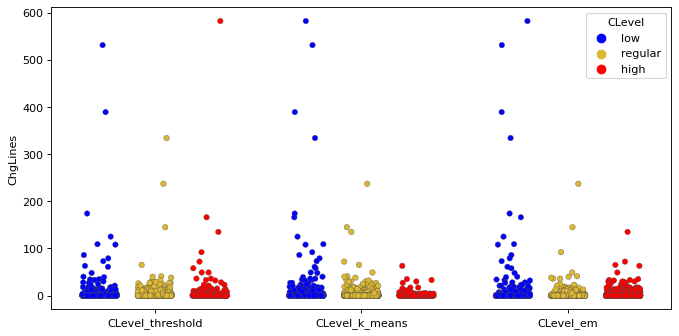

In [17]:
fig, ax = plt.subplots(figsize=(10,5), dpi= 80)    
sns.stripplot(data=m_df, x='CType', y='ChgLines', hue='CLevel',
              palette={'low':'blue', 'regular':'#DCB732', 'high':'red'},
              hue_order=["low", "regular", "high"],
              jitter=0.25, size=5, ax=ax, linewidth=.3, dodge=True)
# plt.title('Results for the threshold approach')
plt.xlabel('')
plt.show()

# Changed lines correlation with the other metrics

In [18]:
scaled_data = df.copy()
list_columns = ['LOC', 'CC', 'NP', 'NV', 'NEST', 'Ca', 'Ce', 'NChg', 'NCall', 'ChgLines']

for col_name in list_columns:
    col = scaled_data[col_name]
    min_col, max_col = col.min(), col.max()
#     min_col = 0  # consider min as 0 to perserve the importance of values; eg LOC 25, 50 -> 0.5, 1 
#     print(col_name, min_col, max_col)
    scaled_data[col_name] = (col - min_col) / (max_col - min_col)
    
scaled_data

,Method,LOC,CC,NP,NV,NEST,Ca,Ce,NChg,NCall,CLevel_threshold,CLevel_k_means,CLevel_em,Previous_Method_Parsed,ChgLines
0,ShareX.ScreenCaptureLib.WindowInfo.WindowInfo(...,0.001821,0.000000,0.1,0.000000,0.0,0.053763,0.000000,0.00,0.000000,low,regular,high,ShareX.ScreenCaptureLib.WindowInfo.WindowInfo(...,0.000000
1,ShareX.ScreenCaptureLib.WindowInfo.Activate(),0.000000,0.000000,0.0,0.000000,0.0,0.010753,0.009217,0.00,0.000000,low,low,low,ShareX.ScreenCaptureLib.WindowInfo.Activate(),0.001718
2,ShareX.ScreenCaptureLib.WindowInfo.ToString(),0.000000,0.000000,0.0,0.014925,0.0,0.000000,0.004608,0.00,0.000000,low,low,low,ShareX.ScreenCaptureLib.WindowInfo.ToString(),0.000000
3,ShareX.HelpersLib.CustomToolStripProfessionalR...,0.001821,0.000000,0.0,0.000000,0.0,0.021505,0.000000,0.00,0.000000,low,low,low,ShareX.HelpersLib.CustomToolStripProfessionalR...,0.000000
4,ShareX.HelpersLib.LabeledComboBox.LabeledCombo...,0.003643,0.000000,0.0,0.000000,0.0,0.010753,0.004608,0.00,0.000019,regular,low,low,ShareX.HelpersLib.LabeledComboBox.LabeledCombo...,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2107,"ShareX.Setup.Helpers.Zip(String,String)",0.001821,0.000000,0.2,0.029851,0.0,0.010753,0.000000,0.00,0.000000,low,regular,high,"ShareX.Setup.Helpers.Zip(String,String)",0.024055
2108,"ShareX.Setup.Helpers.CheckArguments(String[],S...",0.012750,0.031496,0.2,0.089552,0.3,0.010753,0.000000,0.00,0.000000,regular,regular,high,"ShareX.Setup.Helpers.CheckArguments(String[],S...",0.000000
2109,ShareX.NativeMessagingHost.Program.Main(String[]),0.007286,0.015748,0.1,0.029851,0.2,0.000000,0.009217,0.04,0.000000,low,regular,regular,ShareX.NativeMessagingHost.Program.Main(String[]),0.000000
2110,ShareX.NativeMessagingHost.Program.Run(),0.023679,0.039370,0.0,0.149254,0.3,0.010753,0.032258,0.07,0.000000,regular,low,low,ShareX.NativeMessagingHost.Program.Run(),0.000000


<AxesSubplot:>

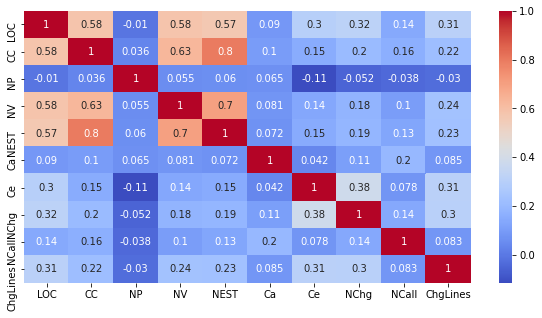

In [19]:
p_corr = scaled_data[list_columns].corr(method='kendall')
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(p_corr, xticklabels=p_corr.columns, yticklabels=p_corr.columns, annot=True, cmap='coolwarm', ax = ax)

<AxesSubplot:>

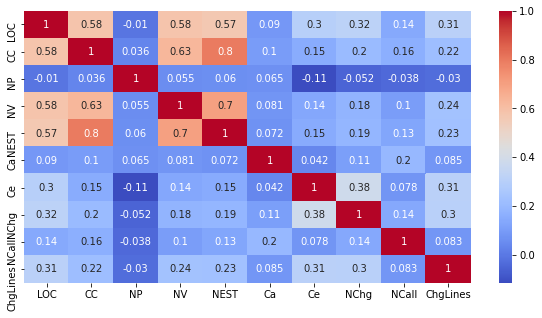

In [20]:
p_corr = df[list_columns].corr(method='kendall')
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(p_corr, xticklabels=p_corr.columns, yticklabels=p_corr.columns, annot=True, cmap='coolwarm', ax = ax)